## import & utils


In [1]:
from collections import namedtuple
from functools import partial
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from types import SimpleNamespace as Bunch
from IPython.display import clear_output, Image
import plotly.graph_objects as go
from ipywidgets import interact
from tqdm.auto import tqdm, trange

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)
    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

In [2]:
import jax
import jax.numpy as jp
import optax

In [3]:
%load_ext autoreload
%autoreload 2

## Params

In [132]:
input_n, output_n = 8, 8
case_n = 1 << input_n
arity, layer_width, layer_n = 4, 64, 3
layer_sizes = (
    [(input_n, 1)]
    + [(layer_width, arity)] * (layer_n - 1)
    + [(layer_width // 2, arity // 2), (output_n, 1)]
)
loss_type = "l4"

In [133]:
layer_sizes

[(8, 1), (64, 4), (64, 4), (32, 2), (8, 1)]

## Training


In [155]:
from model import gen_circuit, run_circuit, run_layer
from training import TrainState, train_step, unpack, evaluate_and_visualize

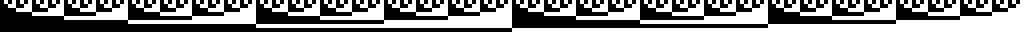

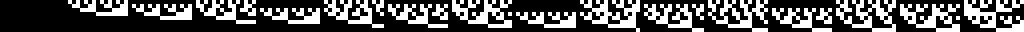

In [135]:
key = jax.random.PRNGKey(42)
wires, logits0 = gen_circuit(key, layer_sizes)

opt = optax.adamw(1e-1, 0.8, 0.8, weight_decay=1e-1)
state = TrainState(params=logits0, opt_state=opt.init(logits0))


x = jp.arange(case_n)
y0 = (x & 0xF) * (x >> 4)
x, y0 = unpack(x), unpack(y0)


imshow(zoom(x.T, 4))
imshow(zoom(y0.T, 4))

In [136]:
loss_log = []

In [137]:
pbar = trange(1000)
for i in pbar:
    loss, accuracy, state = train_step(state, opt, wires, x, y0, loss_type)
    loss_log.append(loss)
    pbar.set_postfix_str(f"loss: {loss.item():.3E}, accuracy: {accuracy.item():.2%}")

  0%|          | 0/1000 [00:00<?, ?it/s]

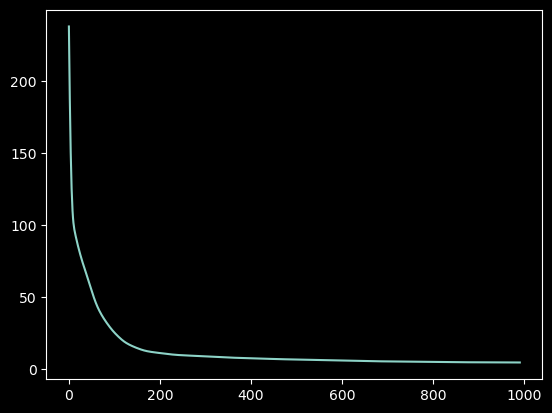

In [138]:
v = len(loss_log) // 100
plt.plot(np.convolve(loss_log, np.ones(v) / v, mode="valid"))

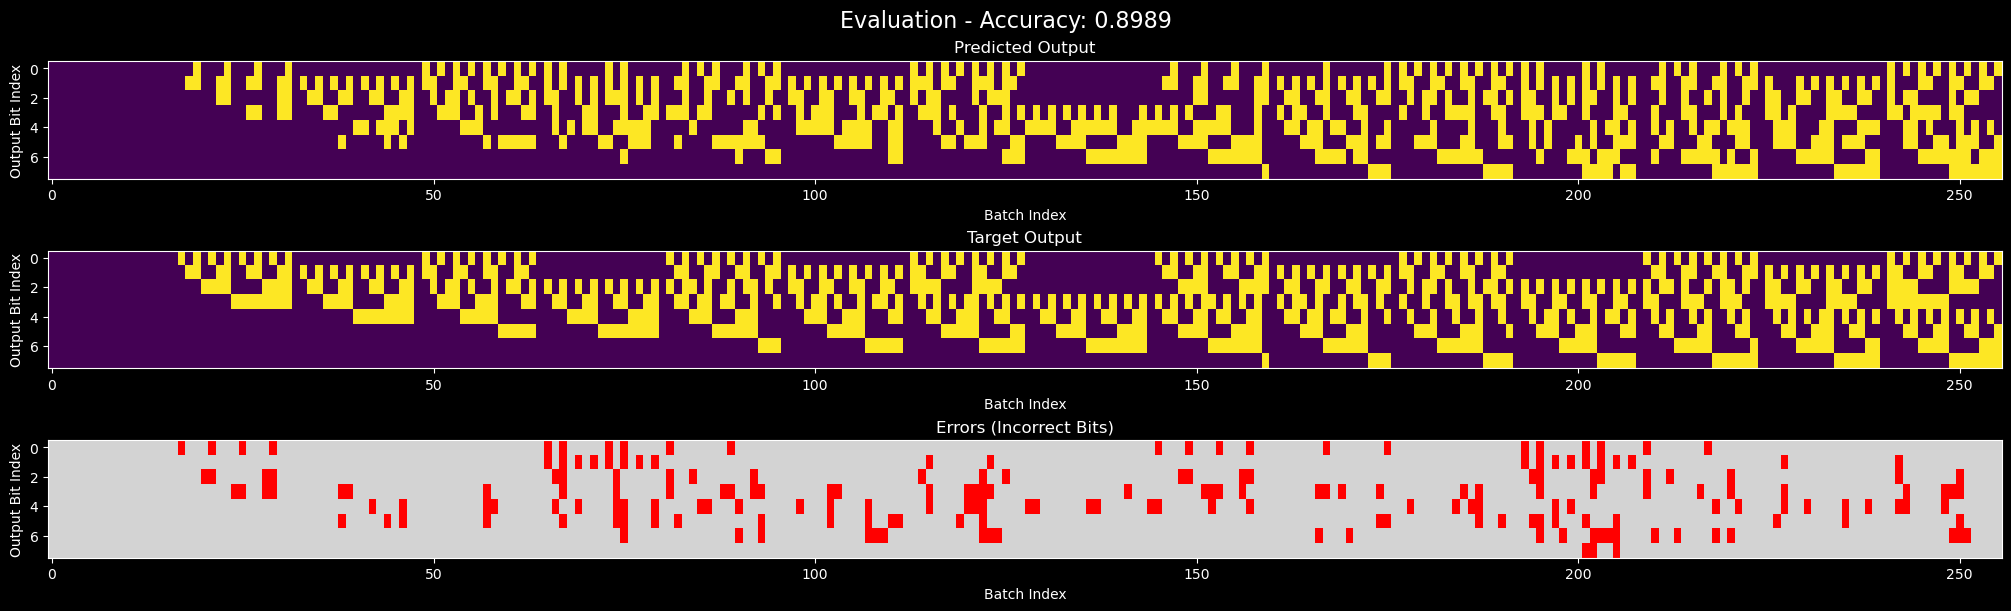

In [172]:
metrics = evaluate_and_visualize(state.params, wires, x, y0, hard=True)

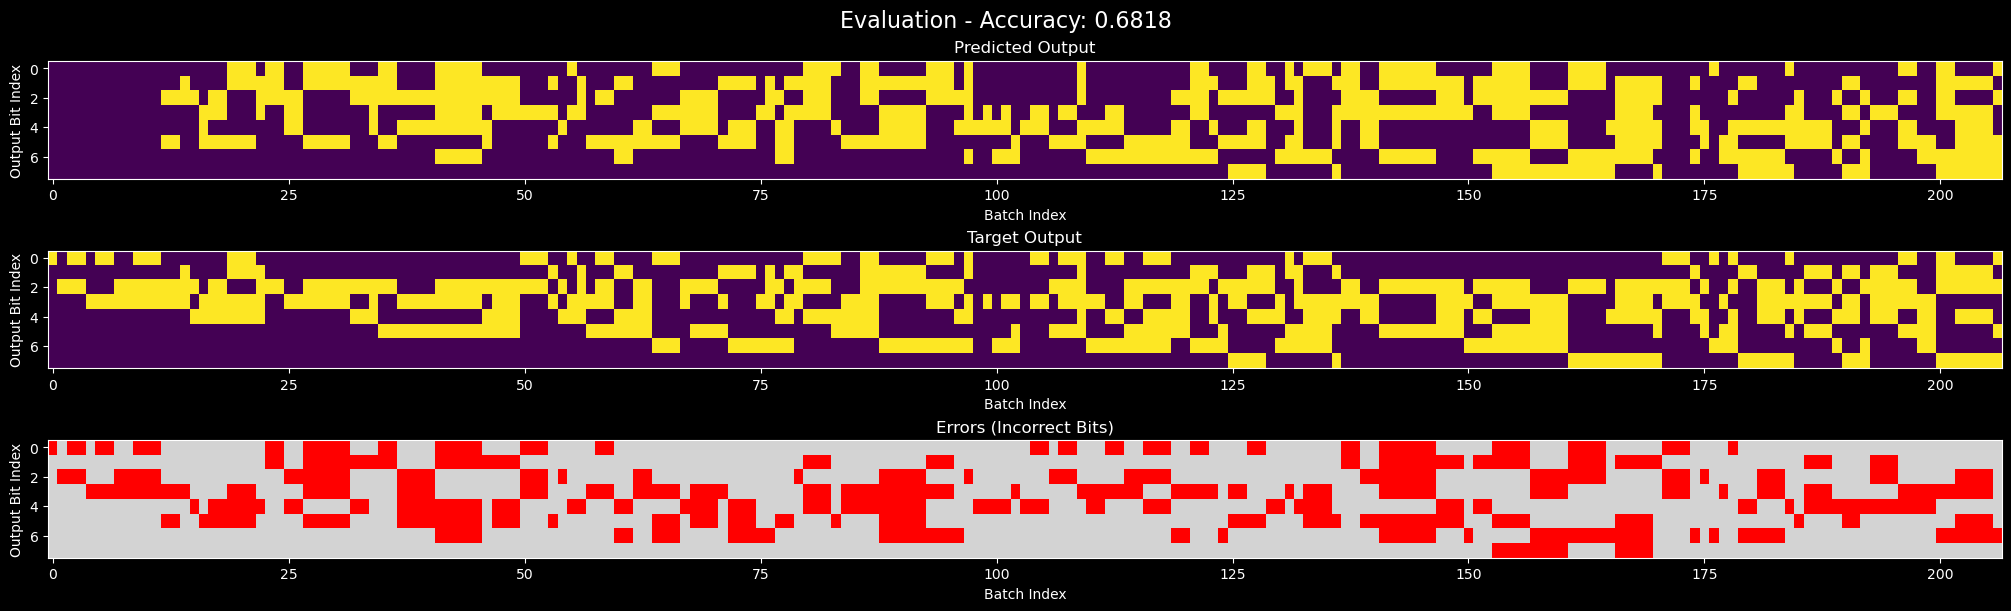

In [177]:
x_faulty = x[metrics["error_locations"]["batch_indices"]]
y_faulty = y0[metrics["error_locations"]["batch_indices"]]
evaluate_and_visualize(state.params, wires, x_faulty, y_faulty, hard=True);

In [198]:
result = run_layer(state.params[0][0], x_faulty)

In [199]:
result

Array([], shape=(0,), dtype=float32)

In [194]:
jp.round(state.params[0])

Array([[[-10.,   0., -10.,   0., -10.,   0., -10.,   0.,  -0.,  10.,
          -0.,  10.,  -0.,  10.,  -0.,  10.]],

       [[-10., -10.,  10.,  10.,  -0.,  -0.,   0.,   0.,  -0.,  -0.,
           0.,   0., -10., -10.,  10.,  10.]],

       [[-10., -10., -10.,  -2., -10., -10.,   0., -10.,   2.,   2.,
          10., -10.,  10.,  10.,  10.,  10.]],

       [[ -0., -10., -10., -10., -10., -10.,   0.,  -0.,  10.,  10.,
         -10.,  10., -10.,  10.,  10.,  10.]],

       [[-10.,  10., -10.,  10.,  -0.,   0.,  -0.,   0.,  -0.,   0.,
          -0.,   0., -10.,  10., -10.,  10.]],

       [[-10., -10.,  10.,  10.,  10.,  10.,  10.,  10., -10., -10.,
          10.,   2.,  -3.,  -0., -10., -10.]],

       [[-10., -10.,  -0.,  -0.,  10.,  10.,   0.,   0.,  -0.,  -0.,
         -10., -10.,   0.,   0.,  10.,  10.]],

       [[-10., -10., -10., -10., -10.,   1., -10.,   1.,  -0., -10.,
          -1.,  -9.,  10.,  10.,  10.,  10.]]], dtype=float32)

In [165]:
import jax.numpy as jp
from model import run_layer

# Define inputs
A, B = 0, 1

# Convert LUT to proper JAX tensor format with required shape
# For run_layer, LUT needs to be a tensor with proper dimensions
lut_values = jp.array([0, 0.5, 0.5, 0], dtype=jp.float32)  # XOR gate
lut = lut_values.reshape(1, 1, 4)  # Shape: [group_n, group_size, 2^arity]

# Prepare inputs as list of tensors (one per input bit)
# Each input should be a separate tensor
input_A = jp.array([[A]], dtype=jp.float32)  # First input bit
input_B = jp.array([[B]], dtype=jp.float32)  # Second input bit
inputs = [input_A, input_B]  # List of input tensors

# Run the layer
result = run_layer(lut, inputs)
print(f"Result: {result}")

Result: [[0.5]]


In [160]:
x.shape

(256, 8)

7